In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import wordcloud as wc
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import os
import pickle
from collections import Counter

sns.set_style("whitegrid")

#GLOBAL VARIABLES
Path='LDA/master/pyext/src/data/'
Images='LDA/master/pyext/src/EDA/Images/'

# EDA 

##  Explore all pathways in KEGG 
## 1.1 Analyze extracted data 

In [3]:
def get_file_handle(Path,fname):
    File_Handle=open(os.path.join(Path+fname),'r+')
    return File_Handle

def print_n_items(dictionary,n):
    n_items=[(k,v) for k,v in list(dictionary.items())[:n]]
    print (n_items)
    
def get_sorted_dict(dictionary):
    sorted_dict= sorted(dictionary.items(), key=lambda x: x[1],reverse=True)
    return sorted_dict

def get_key_from_value(dictionary,val):
    keys=list(dictionary.keys())
    vals=list(dictionary.values())
    return keys[vals.index(val)]

def merge_two_dict(dictionary1,dictionary2):
    dictionary3={get_key_from_value(dictionary2,k):v for k,v in list(dictionary1.items())}
    return dictionary3

def merge_two_dict_key(dictionary1,dictionary2):
    dictionary3={dictionary2[k]:v for k,v in list(dictionary1.items())}
    return dictionary3

def delete_items_from_dict(dictionary,list_big,list_small):
    listn=[i for i in list_big if i not in list_small]
    for i in listn:
        del dictionary[i]
    return dictionary

In [4]:
fname='pathway_ID.csv'

pathway_name_dict={item.strip().split(':')[0]:item.strip().split(':')[1].replace('__',' ').replace('_',' ') 
                   for num,item in enumerate(get_file_handle(Path,fname).readlines())}
#print (pathway_name_dict)

### We are only interested in pathways found in Prokaryotes. We can fetch a list of Prokaryotic organisms from KEGG, and extract pathways associated with each organism. 

In [5]:
fname='prok_path_stats.csv'
path_stats={pathway_name_dict[item.strip().split(':')[0].replace('mapmap','map')]:int(item.strip().split(':')[1]) 
            for num,item in enumerate(get_file_handle(Path,fname).readlines())}

print_n_items(path_stats,5)

[('Glycolysis / Gluconeogenesis', 5764), ('Citrate cycle (TCA cycle)', 5688), ('Pentose phosphate pathway', 5733), ('Pentose and glucuronate interconversions', 5207), ('Fructose and mannose metabolism', 5735)]


In [6]:
sorted_path_stats=get_sorted_dict(path_stats)
print (sorted_path_stats[:5])
#print (get_key_from_value(pathway_name_dict,sorted_path_stats[0][0]))


[('Ribosome', 5791), ('Aminoacyl-tRNA biosynthesis', 5790), ('RNA degradation', 5789), ('Carbon metabolism', 5788), ('Biosynthesis of amino acids', 5787)]


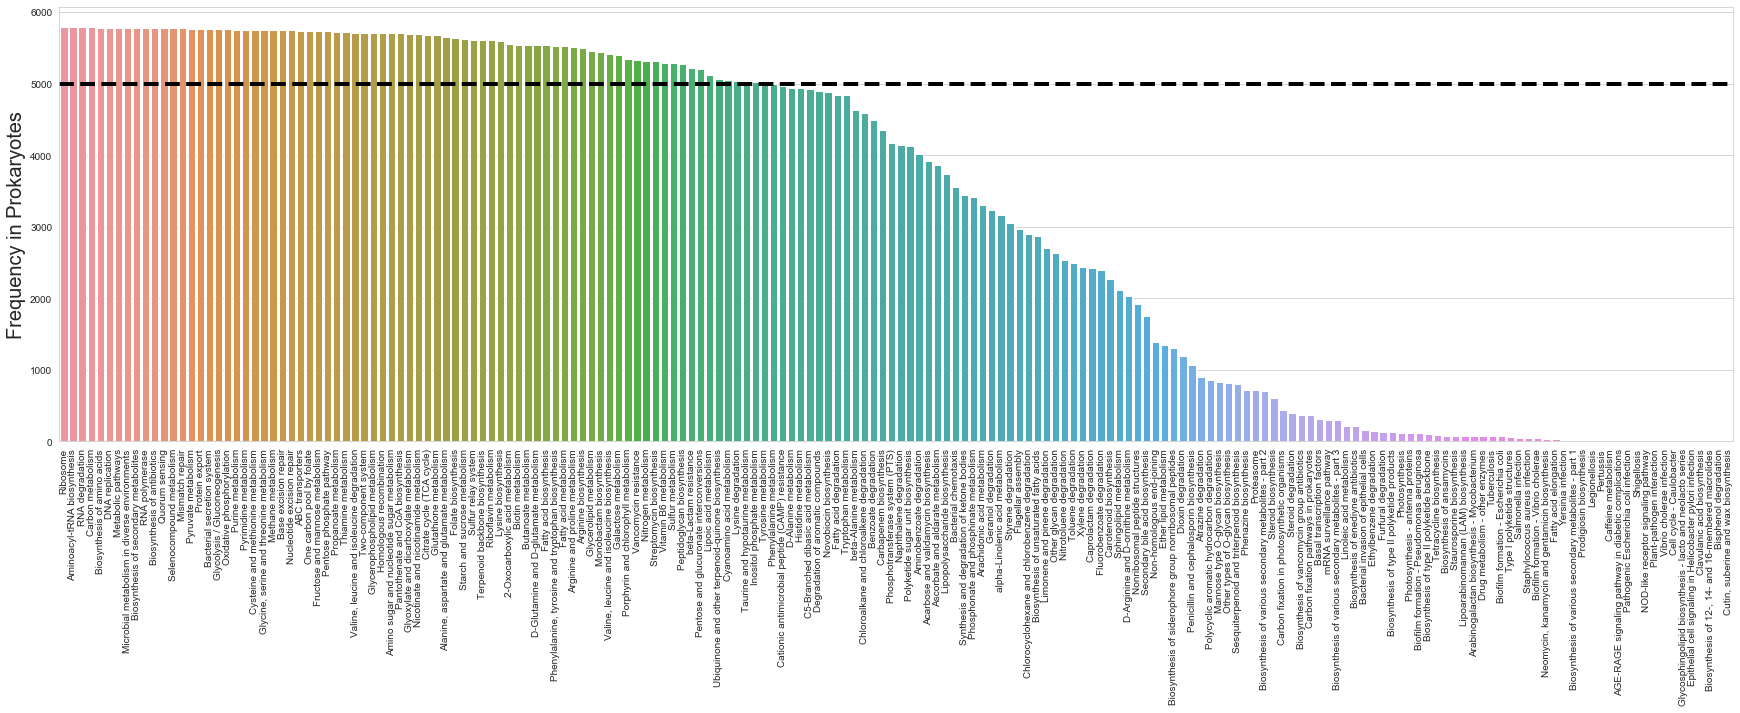

In [7]:
plt.figure(figsize=(30,8))
g=sns.barplot(x=[i[0] for i in sorted_path_stats],y=[i[1] for i in sorted_path_stats],)
sns.set_style("whitegrid")
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_xlabel('');
g.set_ylabel('Frequency in Prokaryotes',fontsize=20);
plt.axhline(y=5000,linewidth=4,color='k',linestyle='--');
plt.savefig(Images+'Pathway_stats.eps',type='eps');

### More frequent (F) pathways (F>5000)

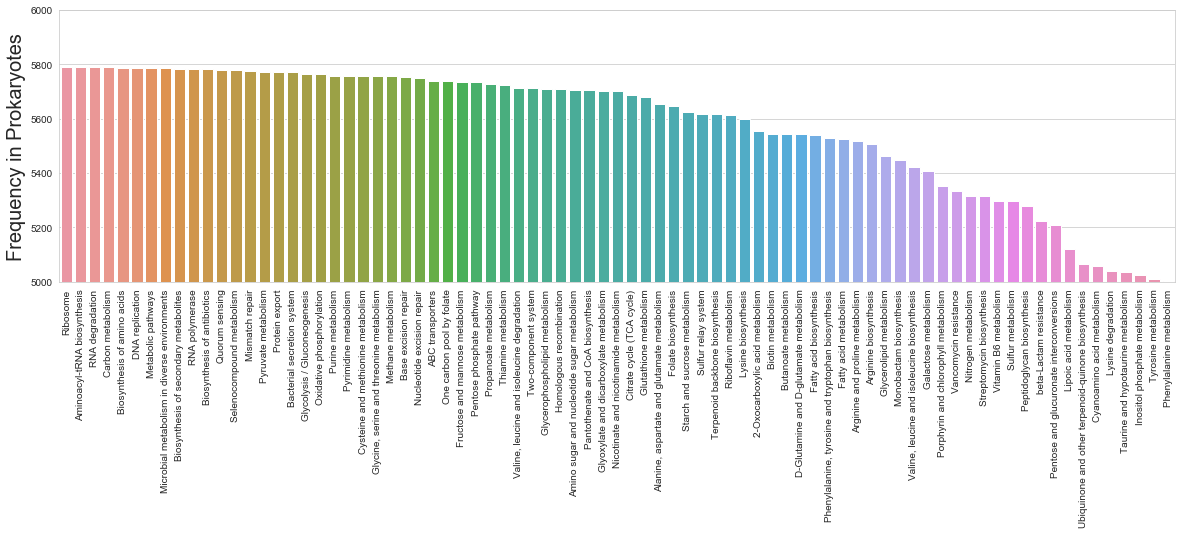

In [9]:
more_freq_stats=[(i[0],i[1]) for i in sorted_path_stats if i[1]>5000]
plt.figure(figsize=(20,5))
g=sns.barplot(x=[i[0] for i in more_freq_stats],y=[i[1] for i in more_freq_stats],)
sns.set_style("whitegrid")
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_xlabel('');
g.set_ylim([5000,6000])
g.set_ylabel('Frequency in Prokaryotes',fontsize=20);
plt.savefig(Images+'Pathway_stats_more.eps',type='eps');

### Less frequent (F) pathways (F<3000)

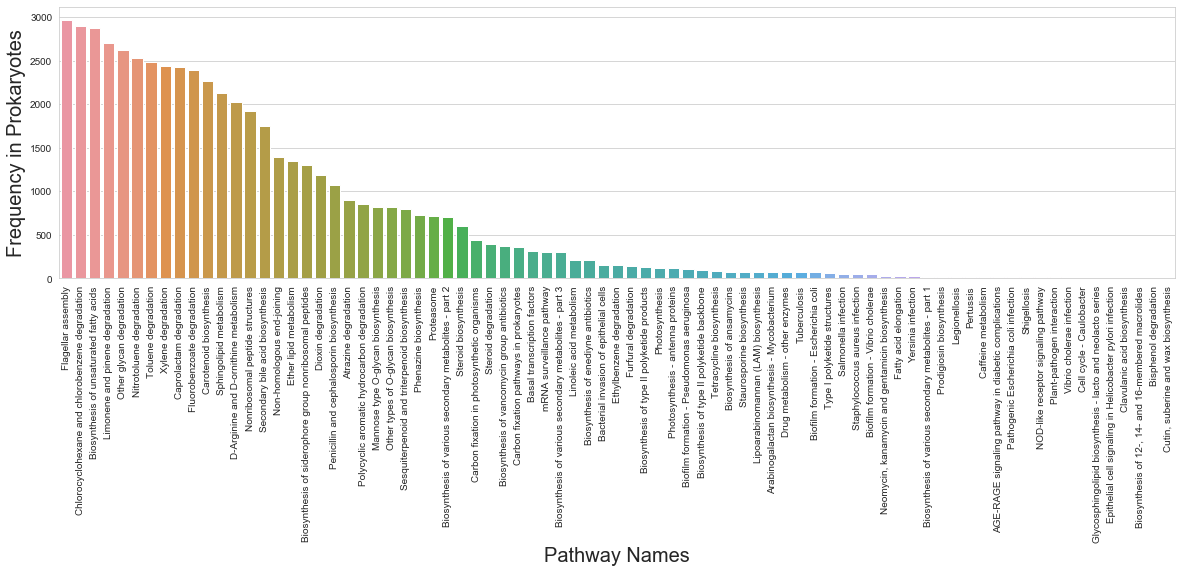

In [10]:
more_freq_stats=[(i[0],i[1]) for i in sorted_path_stats if i[1]<=3000]
plt.figure(figsize=(20,5))
g=sns.barplot(x=[i[0] for i in more_freq_stats],y=[i[1] for i in more_freq_stats],)
sns.set_style("whitegrid")
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_xlabel('Pathway Names',fontsize=20);
g.set_ylabel('Frequency in Prokaryotes',fontsize=20);
plt.savefig(Images+'Pathway_stats_less.eps',type='eps');

###  Inference: From a total of 534 pathways listed in KEGG, we were able to isolate prokaryotic pathways (total 184). However, _Ribosome_ is listed as a top pathway, but it isn't a pathway but an organelle! We have to clean the dataset, we can do this by eliminating pathways that do not have reactions associated with them. We also have a set of pathways that aren't represented well, we need to weight these accoringly in our model.

## 1.2 Data cleaning

### Step 1:  Remove pathways that do not have reactions listed 

In [11]:
fname='rxn_pathways.csv'
rxn_map_keys={item.strip().split('\t')[0].split(':')[1]:item.strip().split('\t')[1].split(':')[1] 
            for num,item in enumerate(get_file_handle(Path,fname).readlines()) 
            if len(item)>1}
print_n_items(rxn_map_keys,5)

[('map00780', 'R10699'), ('map00350', 'R12252'), ('map00970', 'R08578'), ('map00785', 'R12450'), ('map00642', 'R05745')]


In [13]:
list_small=list(rxn_map_keys.keys())
list_big=[get_key_from_value(pathway_name_dict,i[0]) for i in sorted_path_stats]
map_stats=merge_two_dict(path_stats,pathway_name_dict)


delete_items_from_dict(map_stats,list_big,list_small)
#check
print (len(list_small), len(list_big), len(list(map_stats.items())))
print_n_items(map_stats,5)

cleaned_pathways=get_sorted_dict({pathway_name_dict[k]:v for k,v in list(map_stats.items())})
print(cleaned_pathways[:5], len(cleaned_pathways))

135 184 135
[('map00010', 5764), ('map00020', 5688), ('map00030', 5733), ('map00040', 5207), ('map00051', 5735)]
[('Aminoacyl-tRNA biosynthesis', 5790), ('Carbon metabolism', 5788), ('Biosynthesis of amino acids', 5787), ('Metabolic pathways', 5785), ('Microbial metabolism in diverse environments', 5785)] 135


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


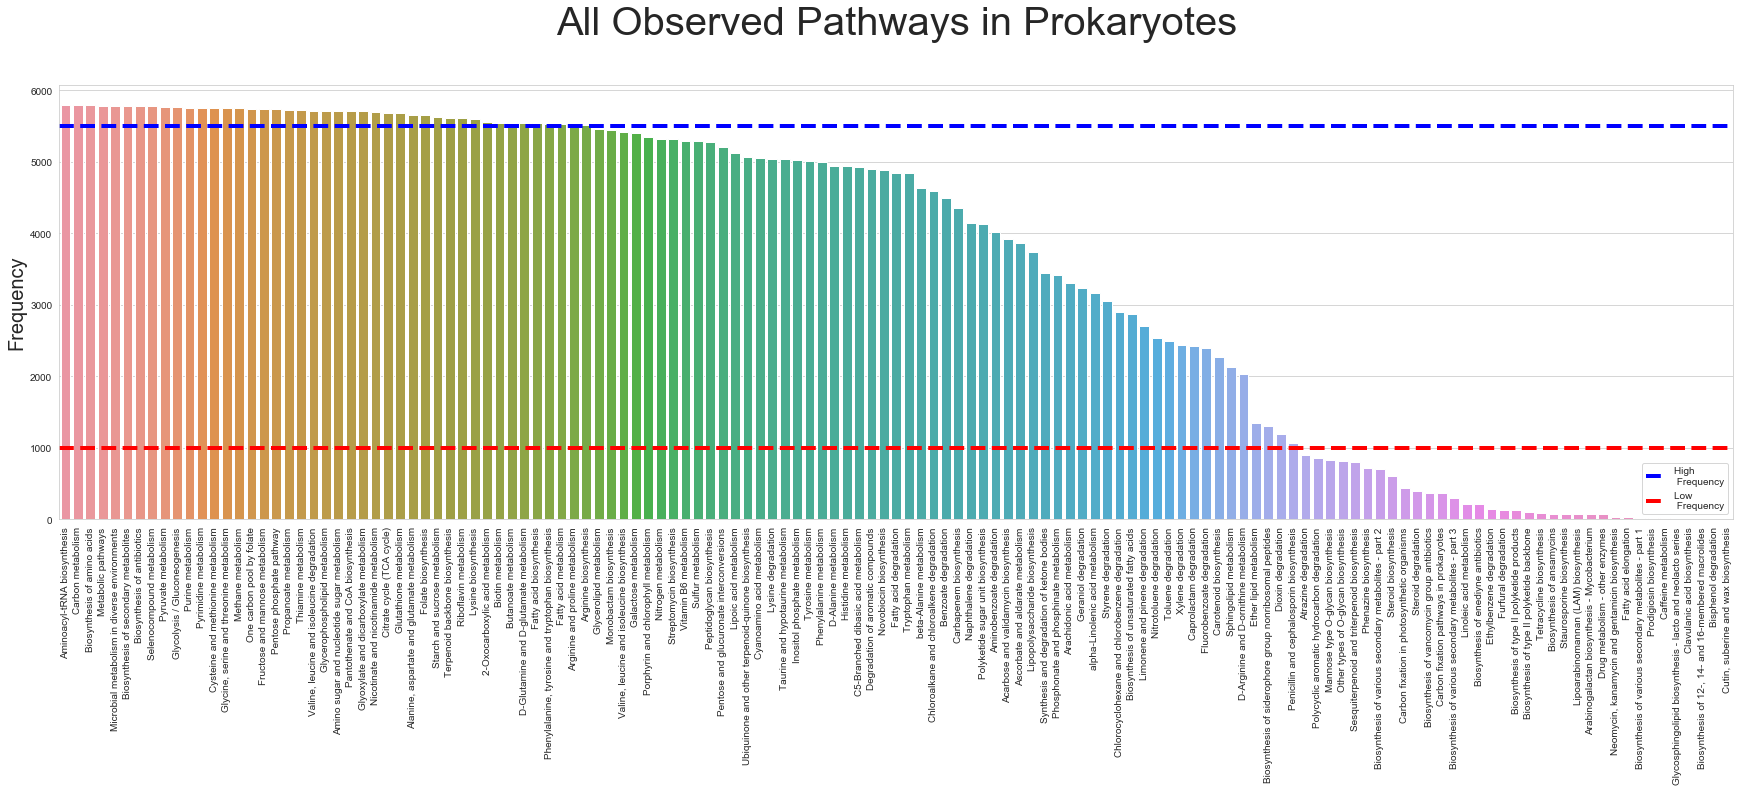

In [14]:
plt.figure(figsize=(30,8))
g=sns.barplot(x=[i[0] for i in cleaned_pathways],y=[i[1] for i in cleaned_pathways],)
sns.set_style("whitegrid")
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_ylabel('Frequency',fontsize=20);
g.set_title('All Observed Pathways in Prokaryotes',fontsize=40,pad=50,)
plt.axhline(y=5500,linewidth=4,color='b',linestyle='--',label='High \n Frequency');
plt.axhline(y=1000,linewidth=4,color='r',linestyle='--',label='Low \n Frequency');
plt.legend()
plt.savefig(Images+'Pathway_stats_clean.eps',type='eps');

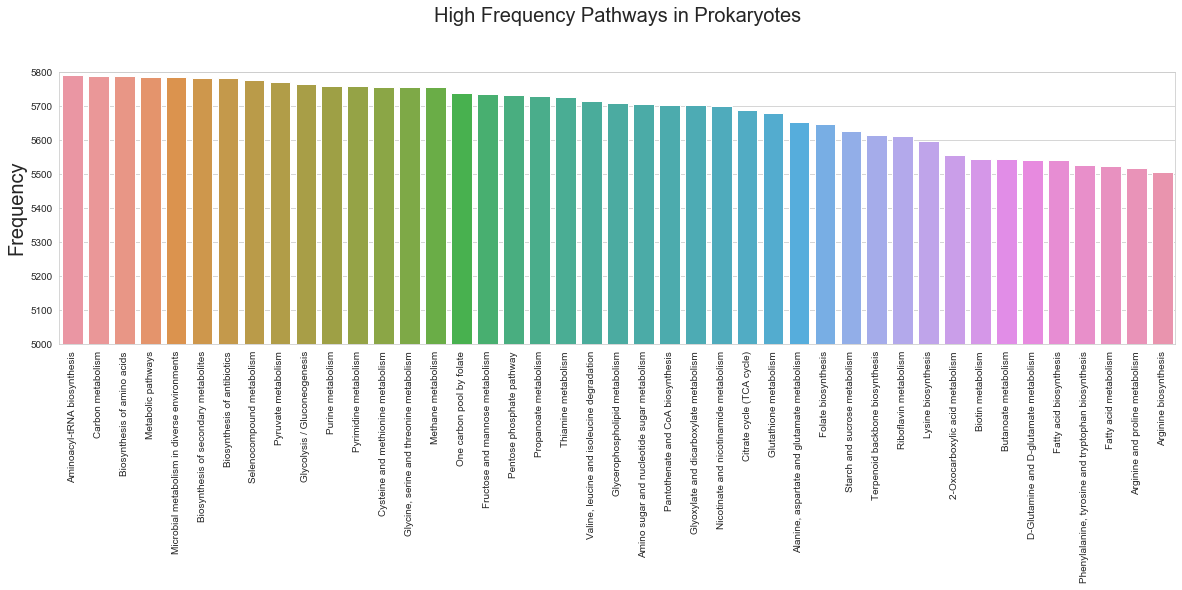

In [15]:
more_freq_stats=[(i[0],i[1]) for i in cleaned_pathways if i[1]>5500]
plt.figure(figsize=(20,5))
g=sns.barplot(x=[i[0] for i in more_freq_stats],y=[i[1] for i in more_freq_stats], )
sns.set_style("whitegrid")
sns.set(font_scale=1.3)
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_xlabel('');
g.set_ylabel('Frequency',fontsize=20,);
g.set_ylim([5000,5800])
g.set_title('High Frequency Pathways in Prokaryotes',fontsize=20,pad=50);  
plt.savefig(Images+'Pathway_stats_more_clean.eps',type='eps');

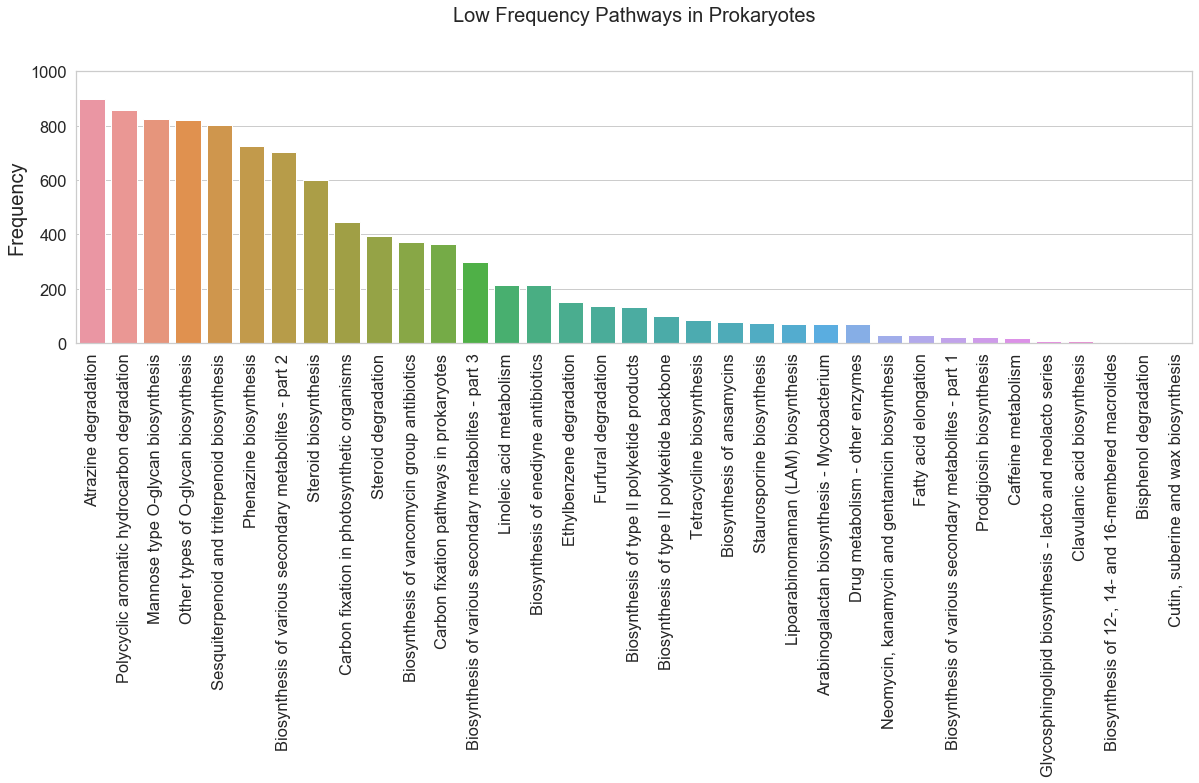

In [20]:
less_freq_stats=[(i[0],i[1]) for i in cleaned_pathways if i[1]<=1000]
plt.figure(figsize=(20,5))
g=sns.barplot(x=[i[0] for i in less_freq_stats],y=[i[1] for i in less_freq_stats],)
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
g.set_xticklabels(g.get_xticklabels(),rotation=90);
#g.set_xlabel('Pathway Names',fontsize=20,style='italic');
g.set_ylabel('Frequency',fontsize=20);
g.set_title('Low Frequency Pathways in Prokaryotes',fontsize=20,pad=50)
sns.set_style("whitegrid")
g.set_ylim([0,1000])
plt.savefig(Images+'Pathway_stats_less_clean.eps',type='eps');

## Inference: We removed 49 non-existing pathways from our dataset by looking for associated reactions. Since we only care about metabolic pathways, we need to remove signaling pathways, disease-associated pathways etc from our dataset. 

### Step 2: Remove pathways with reactions that do not have enzymes listed (this will help us remove signaling pathways and disease associated pathways)

In [77]:
fname='rxn_pathways.csv'
rxn_map_keys={item.strip().split('\t')[0].split(':')[1]:item.strip().split('\t')[1].split(':')[1] 
            for num,item in enumerate(get_file_handle(Path,fname).readlines()) 
            if len(item)>1}
print_n_items(rxn_map_keys,5)

[('map00780', 'R10699'), ('map00350', 'R12252'), ('map00970', 'R08578'), ('map00785', 'R12450'), ('map00642', 'R05745')]


In [78]:
fname='ec_gram.csv'
ec_map=list(set([i.strip().split(':')[0] for i in get_file_handle(Path,fname)]))
print (ec_map[:5])
print (len(ec_map))

['map00365', 'map00020', 'map01057', 'map01100', 'map00052']
135


### All our pathways are now metabolic pathways. We can look into frequency of pathways to understand potentially bias or over-representation in the dataset. 

In [24]:
file='ec_table.csv'
df=pd.read_csv(Path+file,names=['Map','Rxn','EC'],header=None)
metabolic_pathways=list(set(df['Map'].values.tolist()))
print (len(metabolic_pathways))
#print (metabolic_pathways)

135


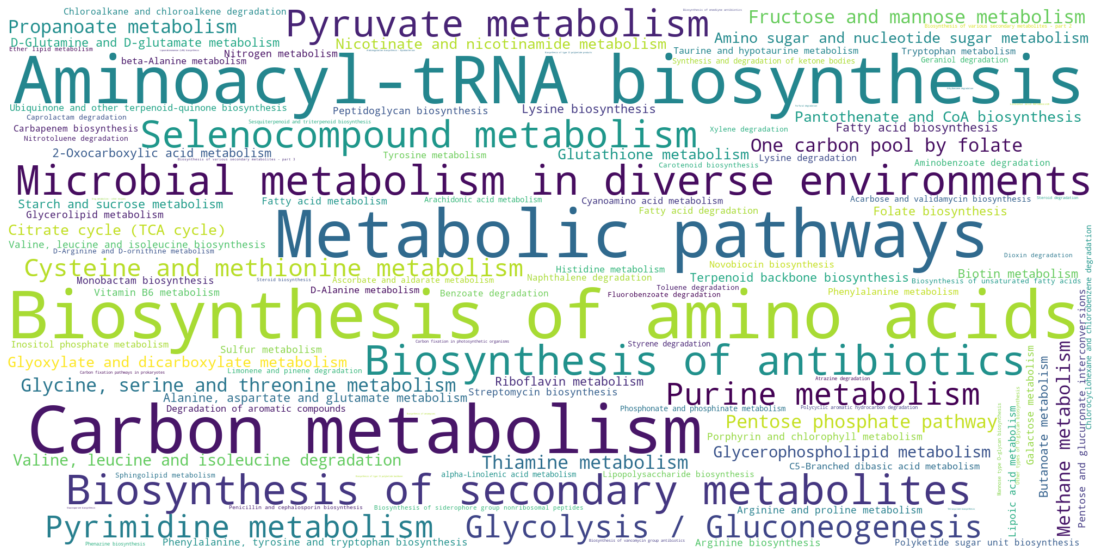

In [482]:
cleaned_pathway_counter={k[0]:k[1] for k in cleaned_pathways}
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate_from_frequencies(cleaned_pathway_counter)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')

plt.axis("off")
plt.savefig(Images+'pathways_prokaryotes_wc.png',type='png')


## Inference: Most common pathways are synthesis related pathways, as one might expect. The database has representative fatty acid, amino acid, nucleic acids and carbohydrate pathways, errors associated with these predictions could be less.

### Step 3: Analyzing reactions 

In [25]:
df_RXN=df.groupby(['Rxn']).count().reset_index('Rxn').sort_values('Map')[::-1]
print (df_RXN[:10])

        Rxn  Map  EC
122  R00256   48  48
114  R00238   36  36
393  R00734   36  36
362  R00694   28  28
178  R00351   27  27
802  R01388   24  24
171  R00342   22  22
685  R01196   22  22
118  R00248   21  21
671  R01175   21  21


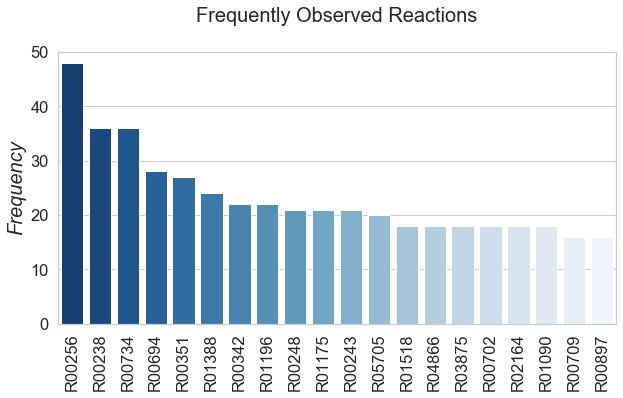

In [26]:
plt.figure(figsize=(10,5))
g1=sns.barplot(x='Rxn',y='Map',data=df_RXN[:20],palette='Blues_r')
sns.set_style("whitegrid")

sns.set(font_scale=1.5)
g1.set_xticklabels(g1.get_xticklabels(),rotation=90);

g1.set_xlabel('');

g1.set_ylabel('Frequency',fontsize=20,style='italic');

g1.set_title('Frequently Observed Reactions',fontsize=20,pad=30)
g1.set_ylim([0,50])
sns.set_style("whitegrid")

plt.savefig(Images+'Rxn.eps',type='eps');
plt.show()

        Rxn  Map  EC
122  R00256   48  48
114  R00238   36  36
393  R00734   36  36
362  R00694   28  28
178  R00351   27  27
802  R01388   24  24
171  R00342   22  22
685  R01196   22  22
118  R00248   21  21
671  R01175   21  21


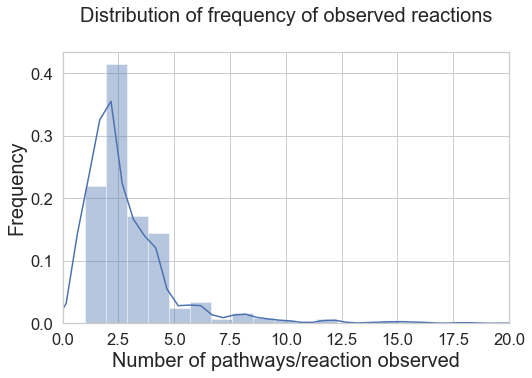

In [28]:
df_maps=df.groupby(['Rxn']).count().reset_index('Rxn')
df_maps_sorted=df_maps.sort_values('Map')
df_maps_sorted.columns
df_maps_sorted_reverse=df_maps_sorted[::-1]
print (df_maps_sorted_reverse[:10])

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
g=sns.distplot(df_maps_sorted_reverse['Map'],kde=True)
sns.set(font_scale=1.5);
g.set_xlabel('Number of pathways/reaction observed',fontsize=20,);
g.set_ylabel('Frequency',fontsize=20,);
g.set_title('Distribution of frequency of observed reactions',fontsize=20,pad=30)
g.set_xlim([0,20]);
plt.savefig(Images+'Rxn.png',type='png');


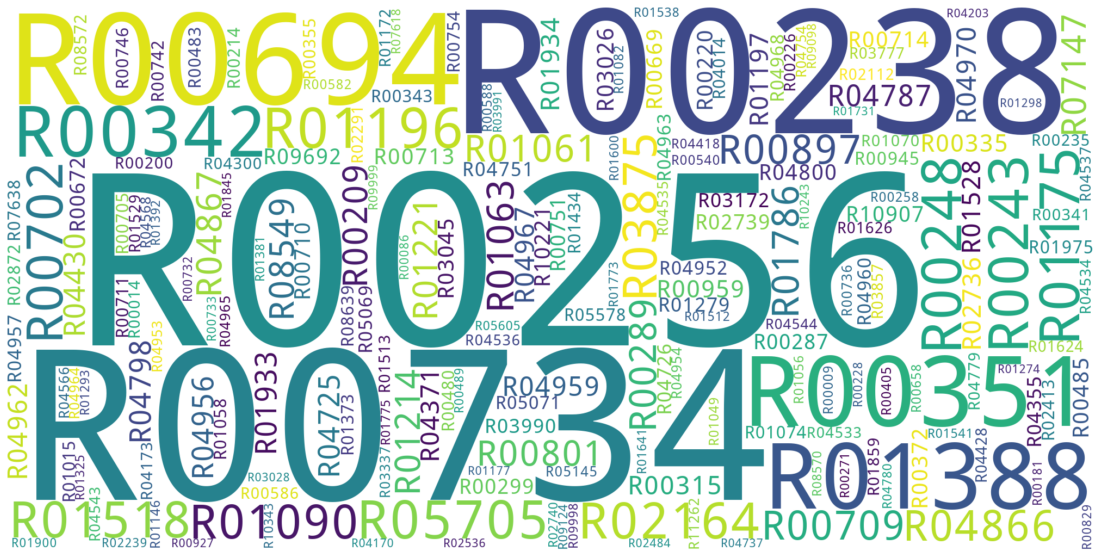

In [485]:
from collections import Counter
word_cloud_dict=Counter(df['Rxn'].values.tolist())
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate_from_frequencies(word_cloud_dict)


plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')

plt.axis("off")
plt.savefig(Images+'RXN_prokaryotes_wc.png',type='png')



## Inference: Most common reactions involve transferases, hydrolases and dehydrogenases.

### Analyzing EC classes

In [41]:
df_EC=df.groupby(['EC']).count().reset_index('EC').sort_values('Map')[::-1]
df1 = df.groupby('Map')['EC'].apply(list).reset_index("Map")
df1['Length']=df1['EC'].str.len()
print (' The minimum pathway length is {}. \n The maximum pathway length is {}. \n The mean pathway length is {}.\n The standard deviation of the pathway length is {}. \n The median pathway length is {}.'.format(np.min(df1['Length']),np.max(df1['Length']),np.mean(df1['Length']),np.std(df1['Length']),np.median(df1['Length'])))



 The minimum pathway length is 3. 
 The maximum pathway length is 4054. 
 The mean pathway length is 105.5037037037037.
 The standard deviation of the pathway length is 385.185205555555. 
 The median pathway length is 39.0.


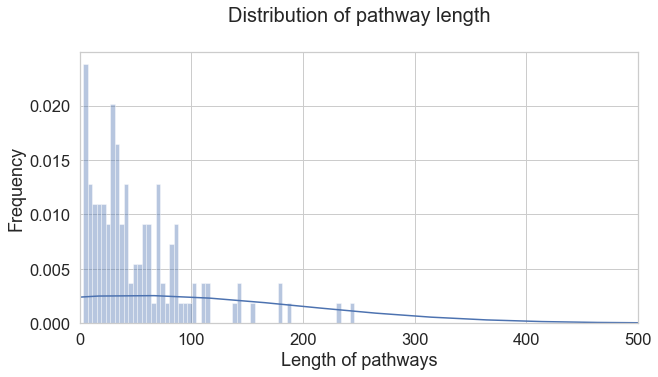

In [530]:
plt.figure(figsize=(10,5))
g=sns.distplot(df1['Length'],bins=1000)
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
#g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_xlabel('Length of pathways');
g.set_ylabel('Frequency');
g.set_title('Distribution of pathway length',fontsize=20,pad=30)
g.set_xlim([0,500])

sns.set_style("whitegrid")
plt.savefig(Images+'pathway_length_dist.png',type='png');

In [30]:
EC_dict={'ec:1':'Oxidoreductases',
         'ec:2':'Transferases',
         'ec:3':'Hydrolases',
         'ec:4':'Lyases',
         'ec:5': 'Isomerases',
          'ec:6': 'Ligases',
          'ec:7':'Translocases'}

EC_dict_numbers={'ec:1':9655,
         'ec:2':6622,
         'ec:3':10604,
         'ec:4':5111,
         'ec:5': 2083,
          'ec:6': 1547,
          'ec:7':966}

dict_Brenda=merge_two_dict_key(EC_dict_numbers,EC_dict)
dict_Brenda_sort=get_sorted_dict(dict_Brenda)
print (dict_Brenda_sort)
df['EC_type']=[EC_dict[i[:4]] for i in df['EC']]
df_EC_type=df.groupby(['EC_type']).count().reset_index('EC_type').sort_values('Map')[::-1]
df_EC_type.head()

[('Hydrolases', 10604), ('Oxidoreductases', 9655), ('Transferases', 6622), ('Lyases', 5111), ('Isomerases', 2083), ('Ligases', 1547), ('Translocases', 966)]


EC_type   Map   Rxn    EC
4  Oxidoreductases  5687  5687  5687
5     Transferases  3931  3931  3931
0       Hydrolases  1715  1715  1715
3           Lyases  1604  1604  1604
1       Isomerases   733   733   733

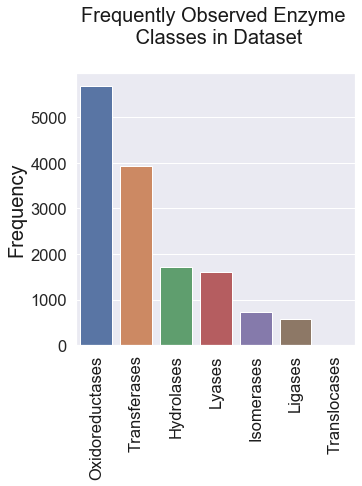

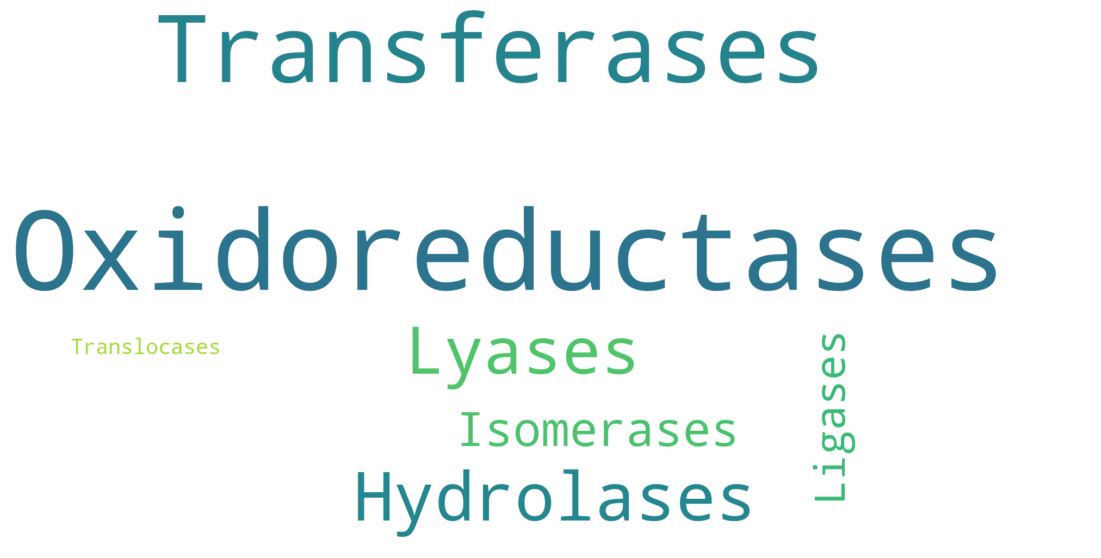

In [32]:
plt.figure(figsize=(5,5))
g=sns.barplot(x='EC_type',y='Map',data=df_EC_type,)
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
g.set_xticklabels(g.get_xticklabels(),rotation=90,color='k');
g.set_xlabel('');
g.set_ylabel('Frequency',fontsize=20,color='k');
g.set_title('Frequently Observed Enzyme \n Classes in Dataset',fontsize=20,pad=30,color='k')
plt.savefig(Images+'EC_top.eps',type='eps');

word_cloud_dict=Counter(df['EC_type'].values.tolist())
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate_from_frequencies(word_cloud_dict)


plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')

plt.axis("off")
plt.savefig(Images+'EC_type_prokaryotes_wc.png',type='png')

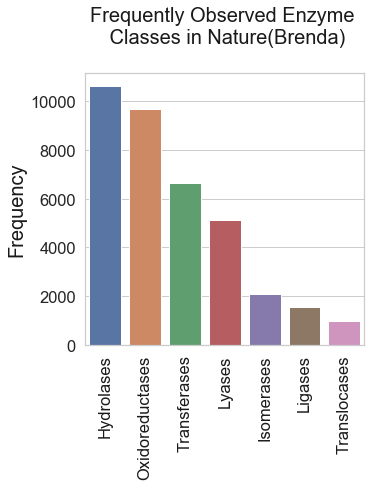

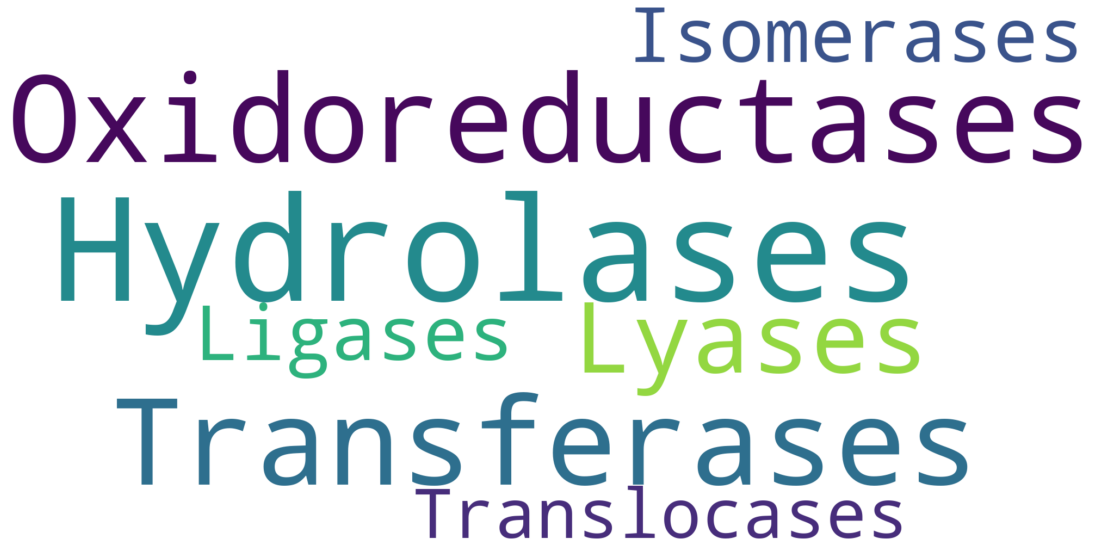

In [627]:
plt.figure(figsize=(5,5))
df_Brenda=pd.DataFrame(dict_Brenda_sort,columns=['EC_type','Numbers'])
#print (df_Brenda.head())
g=sns.barplot(x='EC_type',y='Numbers',data=df_Brenda,)
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
g.set_xticklabels(g.get_xticklabels(),rotation=90,color='k');
g.set_xlabel('');
g.set_ylabel('Frequency',fontsize=20,color='k');
g.set_title('Frequently Observed Enzyme \n Classes in Nature(Brenda)',fontsize=20,pad=30,color='k')
#g.set_ylim([0,50])

sns.set_style("whitegrid")
plt.savefig(Images+'EC_top.eps',type='eps');

word_cloud_dict=Counter(df_Brenda['EC_type'].values.tolist())
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate_from_frequencies(word_cloud_dict)


plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')

plt.axis("off")
plt.savefig(Images+'EC_type_prokaryotes_wc.png',type='png')

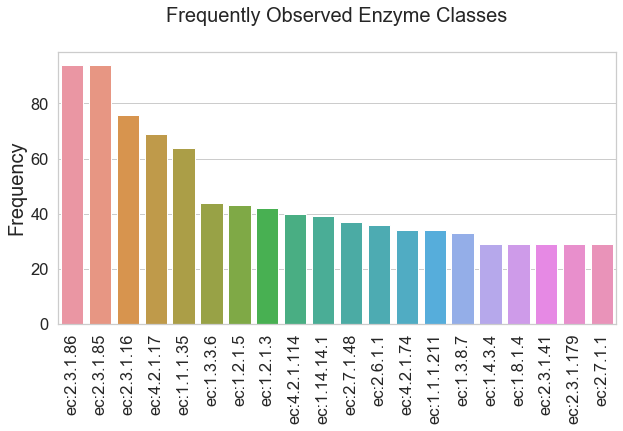

In [39]:
plt.figure(figsize=(10,5))
g=sns.barplot(x='EC',y='Map',data=df_EC[:20],)
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_xlabel('');
g.set_ylabel('Frequency',fontsize=20,);
g.set_title('Frequently Observed Enzyme Classes',fontsize=20,pad=30,)
#g.set_ylim([0,50])

sns.set_style("whitegrid")
plt.savefig(Images+'EC_top.eps',type='eps');

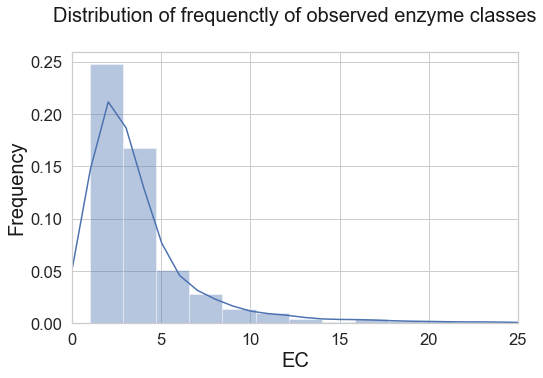

In [40]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
g=sns.distplot(df_EC['Map'])
sns.set(font_scale=1.5);
g.set_xlabel('EC',fontsize=20,color='k');
g.set_ylabel('Frequency',fontsize=20,color='k');
g.set_title('Distribution of frequenctly of observed enzyme classes',fontsize=20,pad=30,color='k')
g.set_xlim([0,25]);
plt.savefig(Images+'EC.png',type='png'); 

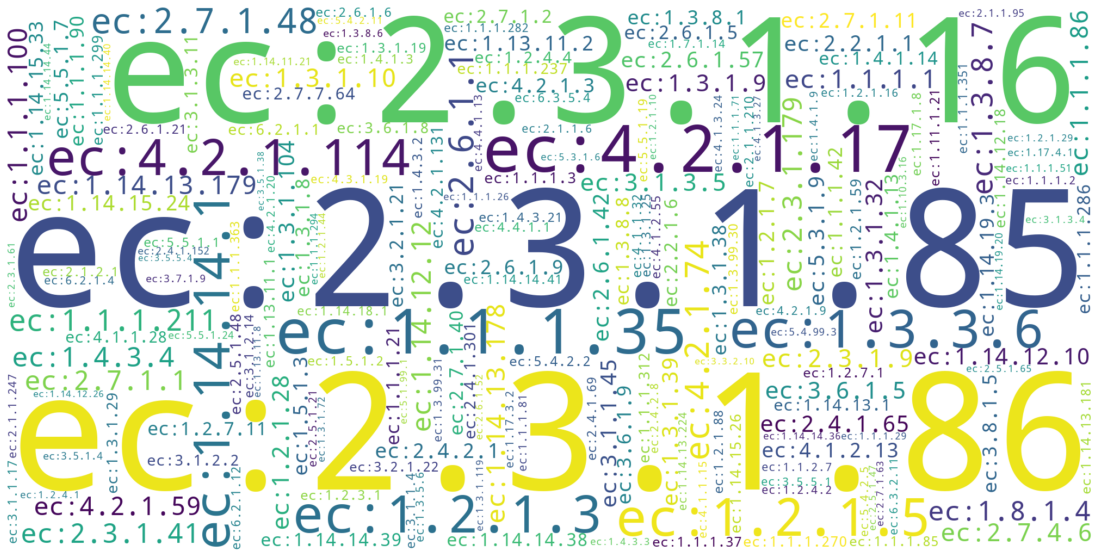

In [478]:
from collections import Counter
word_cloud_dict=Counter(df['EC'].values.tolist())
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate_from_frequencies(word_cloud_dict)


plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')

plt.axis("off")
plt.savefig(Images+'EC_prokaryotes_wc.png',type='png')



## Inference: Most common enzyme class (2.3.1)  is involved in transferring groups that aren't amunoacyl groups between molecules.


In [75]:
file='ec_map_table.csv'
df_new=pd.read_csv(Path+file,names=['Map','EC'],header=None)
metabolic_pathways_new=list(set(df['Map'].values.tolist()))
print (len(metabolic_pathways_new))
#print (metabolic_pathways)
print (df_new)
print (len(metabolic_pathways_new))

135
           Map             EC
0     map00780   ec:1.1.1.100
1     map00780  ec:1.14.14.46
2     map00780    ec:1.3.1.10
3     map00780   ec:2.1.1.197
4     map00780   ec:2.3.1.179
...        ...            ...
9040  map00999    ec:3.1.2.31
9041  map00999    ec:4.2.3.36
9042  map00999     ec:4.2.3.7
9043  map00999    ec:4.4.1.26
9044  map00999    ec:5.5.1.15

[9045 rows x 2 columns]
135


In [82]:
df_new1 = df_new.groupby('Map')['EC'].apply(list).reset_index("Map")
print (df_new1)
df_new1['Length']=df_new1['EC'].str.len()
print (df_new1)
print (' The minimum pathway length is {}. \n The maximum pathway length is {}. \n The mean pathway length is {}.\n The standard deviation of the pathway length is {}. \n The median pathway length is {}.'.format(np.min(df_new1['Length']),np.max(df_new1['Length']),np.mean(df_new1['Length']),np.std(df_new1['Length']),np.median(df_new1['Length'])))

          Map                                                 EC
0    map00010  [ec:1.1.1.1, ec:1.1.1.2, ec:1.1.1.27, ec:1.1.2...
1    map00020  [ec:1.1.1.286, ec:1.1.1.37, ec:1.1.1.41, ec:1....
2    map00030  [ec:1.1.1.215, ec:1.1.1.343, ec:1.1.1.359, ec:...
3    map00040  [ec:1.1.1.10, ec:1.1.1.11, ec:1.1.1.12, ec:1.1...
4    map00051  [ec:1.1.1.11, ec:1.1.1.122, ec:1.1.1.132, ec:1...
..        ...                                                ...
130  map01100  [ec:1.1.1.1, ec:1.1.1.10, ec:1.1.1.100, ec:1.1...
131  map01110  [ec:1.1.1.1, ec:1.1.1.110, ec:1.1.1.122, ec:1....
132  map01120  [ec:1.1.1.1, ec:1.1.1.107, ec:1.1.1.122, ec:1....
133  map01130  [ec:1.1.1.1, ec:1.1.1.133, ec:1.1.1.170, ec:1....
134  map01501                                       [ec:3.5.2.6]

[135 rows x 2 columns]
          Map                                                 EC  Length
0    map00010  [ec:1.1.1.1, ec:1.1.1.2, ec:1.1.1.27, ec:1.1.2...      48
1    map00020  [ec:1.1.1.286, ec:1.1.1.37, ec:1.1.

In [83]:
df_new1.head()

Map                                                 EC  Length
0  map00010  [ec:1.1.1.1, ec:1.1.1.2, ec:1.1.1.27, ec:1.1.2...      48
1  map00020  [ec:1.1.1.286, ec:1.1.1.37, ec:1.1.1.41, ec:1....      26
2  map00030  [ec:1.1.1.215, ec:1.1.1.343, ec:1.1.1.359, ec:...      55
3  map00040  [ec:1.1.1.10, ec:1.1.1.11, ec:1.1.1.12, ec:1.1...      68
4  map00051  [ec:1.1.1.11, ec:1.1.1.122, ec:1.1.1.132, ec:1...      75

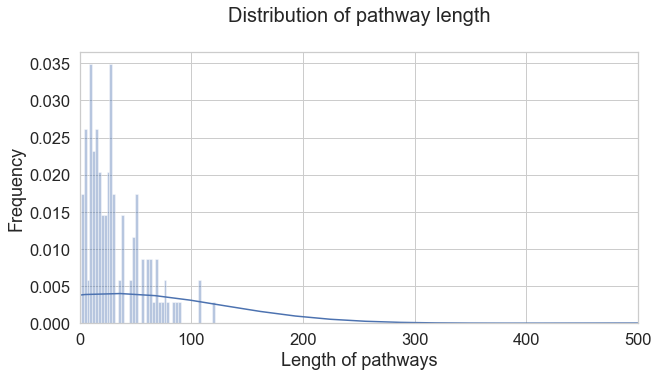

In [84]:
plt.figure(figsize=(10,5))
g=sns.distplot(df_new1['Length'],bins=1000)
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
#g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_xlabel('Length of pathways');
g.set_ylabel('Frequency');
g.set_title('Distribution of pathway length',fontsize=20,pad=30)
g.set_xlim([0,500])

sns.set_style("whitegrid")
plt.savefig(Images+'pathway_length_dist.png',type='png');

In [85]:
df_new['EC']
df_new['EC_type']=[EC_dict[i[:4]] for i in df_new['EC']]
#df_new1['EC_type']=[EC_dict[i[:4]] for i in df_new['EC']]
df_new_EC_type=df_new.groupby(['EC_type']).count().reset_index('EC_type').sort_values('Map')[::-1]
df_new_EC_type.head()

EC_type   Map    EC
4  Oxidoreductases  3200  3200
5     Transferases  2581  2581
3           Lyases  1137  1137
0       Hydrolases  1133  1133
1       Isomerases   551   551

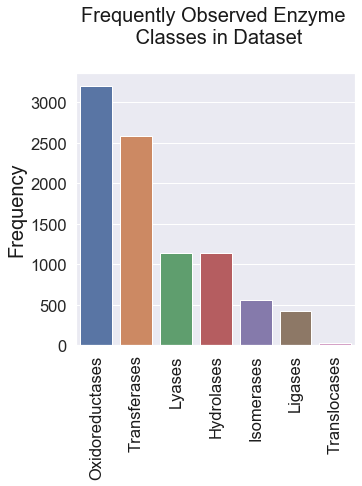

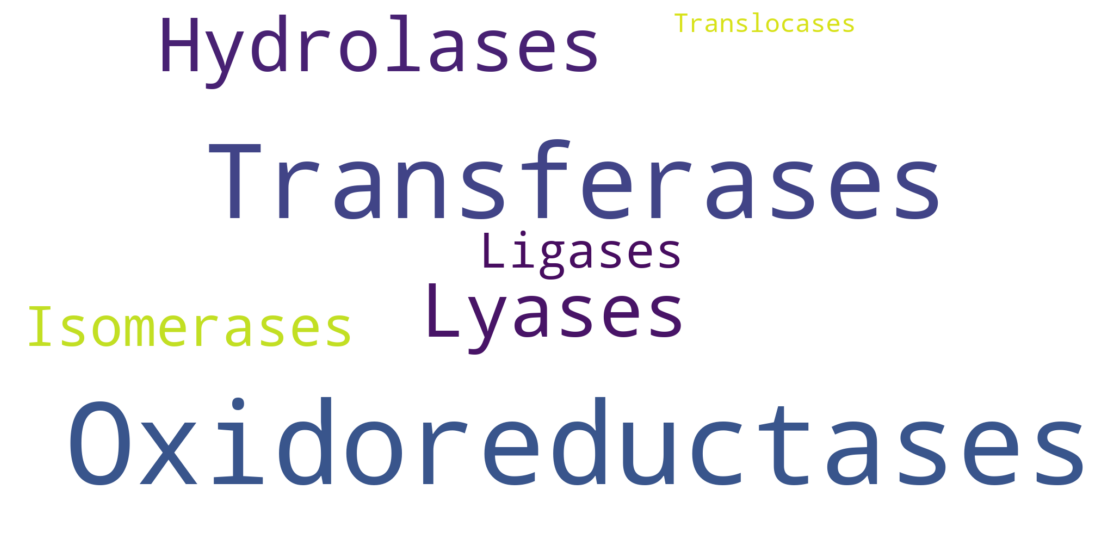

In [87]:
plt.figure(figsize=(5,5))
g=sns.barplot(x='EC_type',y='Map',data=df_new_EC_type,)
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
g.set_xticklabels(g.get_xticklabels(),rotation=90,color='k');
g.set_xlabel('');
g.set_ylabel('Frequency',fontsize=20,color='k');
g.set_title('Frequently Observed Enzyme \n Classes in Dataset',fontsize=20,pad=30,color='k')
plt.savefig(Images+'EC_top.eps',type='eps');

word_cloud_dict=Counter(df_new['EC_type'].values.tolist())
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate_from_frequencies(word_cloud_dict)


plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')

plt.axis("off")
plt.savefig(Images+'EC_type_prokaryotes_wc.png',type='png')